In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import numpy as np
#!pip install pandas
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
class ImageAndPathsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _= super(ImageAndPathsDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        return img, path


Chargement des données

Labels de nos données

Affichage d'un échantillon de posters de notre dataset

In [3]:
mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()]) #,normalize])


dataset = datasets.ImageFolder("C:/Users/lisec/OneDrive/Documents/cours/5A/AIF/Projet/content/sorted_movie_posters_paligema", transform = transform)

train_size = int(0.8 * len(dataset))  # 80% pour l'entraînement
test_size = len(dataset) - train_size  # 20% pour le test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])



train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)  
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

#dataloader = DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False)

In [4]:
dataset.classes

['action',
 'animation',
 'comedy',
 'documentary',
 'drama',
 'fantasy',
 'horror',
 'romance',
 'science Fiction',
 'thriller']

(-0.5, 1809.5, 453.5, -0.5)

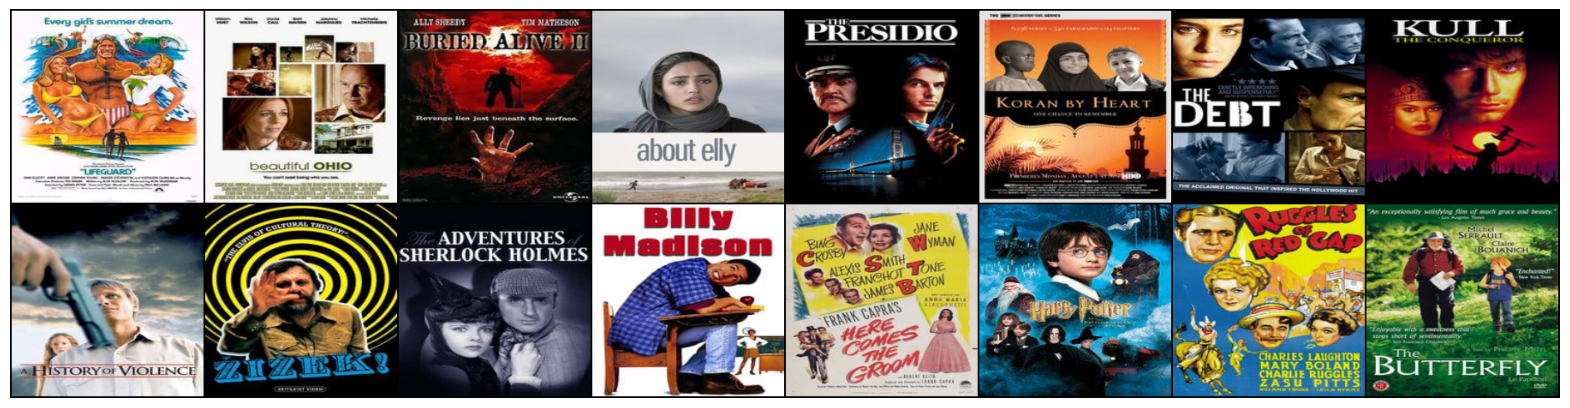

In [5]:
x, paths = next(iter(train_dataloader))
img_grid = make_grid(x[:16])
#img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Mise en place du modèle pré-entrainé

Les architectures ResNet sont souvent utilisés pour des problèmes de classification

In [6]:
#ne pas run
resnet = models.resnet18(pretrained=True)

# Modifier la dernière couche pour le nombre de genres
num_classes = len(dataset.classes)  # Nombre de genres
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

/home/catalogn/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/catalogn/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
#ne pas run
torch.save(resnet.state_dict(), "resnet_genre_classifier.pth")

Modele mobilenet

Utilisation d'un modèle séquentiel pour obtenir uniquement les caractéristiques suivies de la couche avgpool de MobileNet, et terminer par une couche Flatten

In [6]:
mobilenet = models.mobilenet_v3_small(pretrained=True) #1

/home/catalogn/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/catalogn/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
N_genres = len(dataset.classes) #2 

model = nn.Sequential( 
    mobilenet.features,
    mobilenet.avgpool,
    nn.Flatten(),
    nn.Linear(576, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, N_genres)
)
# avec ce modele accuracy train 89%, accuracy test : 37% sur 10 epochs un peu d'overfitting

In [ ]:
"""
(si ca ne marche pas assez bien, essayer de geler les couches avec ce code : 

# Geler toutes les couches sauf les dernières
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Activer l'entraînement uniquement sur la tête
for param in mobilenet.avgpool.parameters():
    param.requires_grad = True """

## Prochaine fois run ce code qui contient gel de couche + fine tuning + bon modele 

In [7]:
# Charger MobileNetV3 Small pré-entraîné
mobilenet = models.mobilenet_v3_small(pretrained=True)

N_genres = len(dataset.classes) 

# Geler toutes les couches
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Construire le modèle avec une tête personnalisée
model = nn.Sequential(
    mobilenet.features,
    mobilenet.avgpool,
    nn.Flatten(),
    nn.Linear(576, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, N_genres)
)

# Optimiseur
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


Autre type de modele mais tres long à entrainer et pas bon

In [8]:
print("Début du chargement du modèle...")
mobilenet = models.mobilenet_v3_small(pretrained=True)

# Geler toutes les couches
print("Gel des paramètres du modèle...")
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Calculer la taille correcte de la sortie après la couche features
dummy_input = torch.randn(1, 3, 224, 224)  # Entrée factice
with torch.no_grad():
    x = mobilenet.features(dummy_input)
    print("Taille de la sortie après la couche features:", x.shape)

# Vérifie si la suite du modèle est bien construite
print("Construction du modèle...")
model = nn.Sequential(
    mobilenet.features,
    mobilenet.avgpool,
    nn.Flatten(),
    nn.Linear(576, 256),  # Ajuste 576 si nécessaire après l'inspection de la forme
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, N_genres)
)

# Vérifier la forme du modèle
print("Vérification du modèle...")
print(model)

# Optimiseur
print("Initialisation de l'optimiseur...")
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Prêt à entraîner le modèle...")


Début du chargement du modèle...
Gel des paramètres du modèle...
Taille de la sortie après la couche features: torch.Size([1, 576, 7, 7])
Construction du modèle...
Vérification du modèle...
Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), str

In [7]:
N_genres = len(dataset.classes)

model = nn.Sequential(
          mobilenet.features,
          mobilenet.avgpool,
          nn.Flatten(),
          nn.Linear(576, N_genres)
        )

In [10]:
from torchvision.models import mobilenet_v3_small
mobilenet = mobilenet_v3_small(pretrained=True)

n = 5  # Nombre de couches à dégeler
total_layers = len(list(mobilenet.features.children()))  # Nombre total de couches
freeze_until = total_layers - n

# Rendre les couches convolutives entraînables
for i, layer in enumerate(mobilenet.features.children()):
    if i < freeze_until:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True


model = nn.Sequential(
    mobilenet.features,
    nn.AdaptiveAvgPool2d(1),  # Remplacez avgpool par une couche adaptative
    nn.Flatten(),
    nn.Linear(1280, 256),  # MobileNetV2 sort 1280 caractéristiques
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, N_genres)  # Prédiction des genres
)


/home/catalogn/.conda/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/catalogn/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 55.0MB/s]


In [11]:
x = torch.zeros(100, 3, 224,224)#.cuda
y = model(x)
y.shape

torch.Size([100, 10])

# Entrainement du modèle 

In [8]:
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_test_print=[0.0]
loss_print=[0.0]

for epoch in range(epochs):
    model.train(
)  
    running_loss = 0.0
    running_loss_test = 0.0
    

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    loss_print.append(running_loss)

    print(f"Epoch(train) [{epoch + 1}/{epochs}], Train Loss: {running_loss / len(train_dataloader):.4f}")


    for inputs_test, labels_test in test_dataloader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

        outputs_test = model(inputs_test).to(device)

        loss_test = criterion(outputs_test, labels_test)

        running_loss_test += loss_test.item()
    loss_test_print.append(running_loss_test)

    print(f"Epoch(test) [{epoch + 1}/{epochs}], Test Loss: {running_loss_test / len(test_dataloader):.4f}")

#plot(loss_print_test, epochs)
#plot(loss_print, epochs)


Epoch(train) [1/10], Train Loss: 2.1291
Epoch(test) [1/10], Test Loss: 2.0205
Epoch(train) [2/10], Train Loss: 1.9778
Epoch(test) [2/10], Test Loss: 1.9763
Epoch(train) [3/10], Train Loss: 1.9211
Epoch(test) [3/10], Test Loss: 1.9243
Epoch(train) [4/10], Train Loss: 1.8815
Epoch(test) [4/10], Test Loss: 1.8941
Epoch(train) [5/10], Train Loss: 1.8395
Epoch(test) [5/10], Test Loss: 1.8577
Epoch(train) [6/10], Train Loss: 1.8070
Epoch(test) [6/10], Test Loss: 1.8214
Epoch(train) [7/10], Train Loss: 1.7770
Epoch(test) [7/10], Test Loss: 1.8245
Epoch(train) [8/10], Train Loss: 1.7503
Epoch(test) [8/10], Test Loss: 1.7848
Epoch(train) [9/10], Train Loss: 1.7341
Epoch(test) [9/10], Test Loss: 1.7943
Epoch(train) [10/10], Train Loss: 1.7082
Epoch(test) [10/10], Test Loss: 1.7788


Enregistrement des poids des paramètres

In [10]:
torch.save(model.state_dict(), "model_genre_classifier.pth")

Plot des courbes des loss sur l'echantillon train et test

In [11]:
for i in range(len(loss_test_print)):
    loss_test_print[i]=loss_test_print[i]/len(test_dataloader)
    loss_print[i]=loss_print[i]/len(train_dataloader)

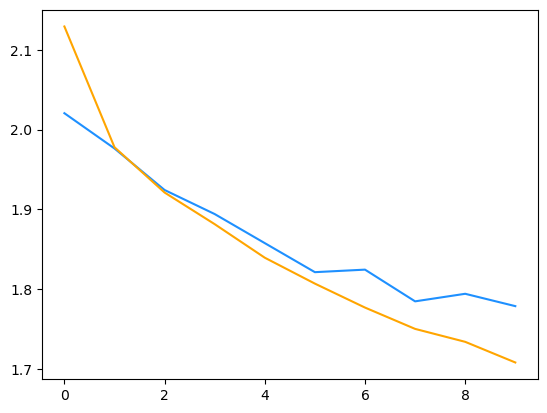

In [12]:
plt.plot(np.arange(epochs), loss_test_print[1:], color='dodgerblue')
plt.plot(np.arange(epochs), loss_print[1:],color='orange')

# Evaluation du modèle

In [16]:
model.eval() 

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
      
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 40.28%


Affichage d'exemple de prédictions

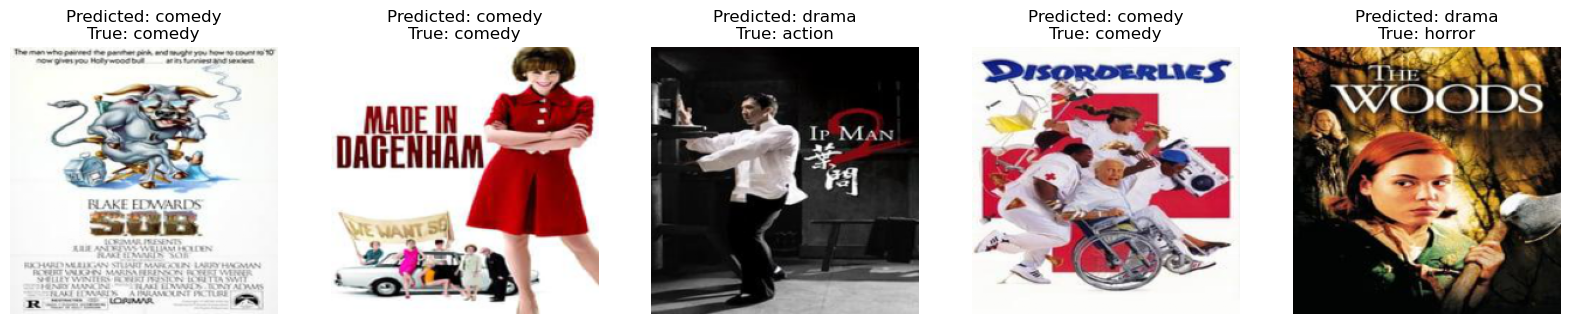

In [14]:
def show_predictions(model, dataloader, num_images=5):
    model = model.to(device)
    model.eval()  
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))    
    
    

    with torch.no_grad():
        for inputs, labels in dataloader:
            #img_grid = make_grid(inputs)
            #img_grid = inv_normalize(img_grid)
            inputs = inputs.to(device)  
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)  
            
            # Afficher les images et les prédictions faites
            
            for i in range(num_images):
                
                ind = np.random.randint(0, inputs.size(0))
               
                if images_shown >= num_images:
                    break
                axes[images_shown].imshow(inputs[ind].cpu().numpy().transpose((1, 2, 0)))  
                axes[images_shown].set_title(f"Predicted: {dataset.classes[preds[ind]]}\nTrue: {dataset.classes[labels[ind]]}")
                axes[images_shown].axis('off')  
                images_shown += 1


        plt.show()

        
show_predictions(model, train_dataloader, num_images=5)
